In [ ]:
import pandas as pd
import numpy as np

# 文件路径，使用需要的交通数据文件
file_path = 'traffic-volume-counts-2012-2013.csv'

# 1. 数据加载与初始检查
print(f"--- 1. 正在加载文件: {file_path} ---")

try:
    # 默认加载 CSV 文件
    df = pd.read_csv(file_path)
    print("数据加载成功！")
except FileNotFoundError:
    print(f"错误：文件未找到。请检查路径：{file_path}")
    # 实际执行时，如果出错，程序将退出
    exit()

# 2. 数据融合：将宽表转为长表
print("\n--- 2. 核心步骤：数据融合 ---")

# 确定 ID 变量：这些列保持不变
id_vars = ['Roadway Name', 'Direction', 'Date']
# 确定需要融合的 Value 变量：从第 7 列到最后一列，即所有的小时流量列
volume_cols = df.columns[7:].tolist()

# 执行数据融合操作
df_melted = df.melt(
    id_vars=id_vars,
    value_vars=volume_cols,
    var_name='Time_Interval', # 新的时间间隔列名 (e.g., '1:00-2:00AM')
    value_name='Volume'        # 新的流量值列名
)

# 3. 数据清洗与特征工程
print("\n--- 3. 正在清洗与提取时间特征 ---")

# A. 清理 Volume 列中的非数值和缺失值
# 'errors=\'coerce\'' 将非数字值（如空白或文本）转换为 NaN
df_melted['Volume'] = pd.to_numeric(df_melted['Volume'], errors='coerce').fillna(0)

# B. 提取精确小时数 (Hour_of_Day)
# 需要精确处理 AM/PM
def map_hour_of_day(time_interval_str):
    # 提取开始的小时数 (e.g., 从 '1:00-2:00 AM' 得到 1)
    try:
        hour_start = int(time_interval_str.split(':')[0])
    except ValueError:
        return np.nan # 格式异常则返回 NaN

    # 判断 AM/PM
    if 'AM' in time_interval_str:
        if hour_start == 12: # 12:00 AM (午夜) 应是 0 点
            return 0
        else: # 1:00 AM - 11:00 AM
            return hour_start
    elif 'PM' in time_interval_str:
        if hour_start == 12: # 12:00 PM (中午)
            return 12
        else: # 1:00 PM - 11:00 PM (需要加 12)
            return hour_start + 12
    else:
        return np.nan # 格式无法识别

df_melted['Hour_of_Day'] = df_melted['Time_Interval'].apply(map_hour_of_day)

# C. 提取日期和星期特征
# 'Date' 格式为 'YYYY-MM-DDTHH:MM:SS.000'，只取日期部分
df_melted['Date'] = pd.to_datetime(df_melted['Date'].str.split('T').str[0])
df_melted['Day_of_Week'] = df_melted['Date'].dt.day_name()
df_melted['Is_Weekend'] = df_melted['Date'].dt.dayofweek >= 5 # 星期六/日为 True

# D. 添加 10% 大型车假设（用于下阶段的诊断）
TRUCK_RATIO = 0.10
df_melted['Truck_Volume'] = df_melted['Volume'] * TRUCK_RATIO
df_melted['Car_Volume'] = df_melted['Volume'] * (1 - TRUCK_RATIO)


# 4. 最终整理与检查
# 筛选掉 Hour_of_Day 为 NaN 的异常行，并转换为整数
df_final = df_melted.dropna(subset=['Hour_of_Day']).copy()
df_final['Hour_of_Day'] = df_final['Hour_of_Day'].astype(int)

# 重命名关键列，使其更符合分析习惯
df_final.rename(columns={'Direction': 'Approach'}, inplace=True)

print("\n--- 4. 数据融合与清洗后的预览---")
core_cols = ['Roadway Name', 'Approach', 'Hour_of_Day', 'Volume', 'Truck_Volume', 'Day_of_Week']
print(df_final[core_cols].head(10))
print(f"\n最终用于下列分析的有效数据集行数: {len(df_final)}")

In [98]:
print("--- 步骤 1: 正在安装中文字体 (文泉驿正黑) ---")
!apt-get -y install fonts-wqy-zenhei

print("--- 步骤 2: 正在动态注册字体到 Matplotlib ---")
from matplotlib import font_manager
import os

# 定义字体文件路径
font_path = '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'

if os.path.exists(font_path):
    # 使用 fontManager.addfont() 动态添加字体
    font_manager.fontManager.addfont(font_path)
    print(f"成功添加字体: {font_path}")
else:
    print(f"警告: 未找到字体文件 {font_path}，请检查步骤1的安装是否成功。")

print("--- 步骤 3: 设置 Matplotlib 全局字体 ---")
import matplotlib.pyplot as plt
import seaborn as sns

# 设置rcParams，告诉 Matplotlib 使用新字体
# 注意：字体名称必须与 Matplotlib 内部识别的名称一致
# 对于文泉驿正黑，通常就是 'WenQuanYi Zen Hei'
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号 '-' 显示为方块的问题

print("--- 所有设置完毕！---")
print("请继续运行你原来的绘图代码。")

--- 步骤 1: 正在安装中文字体 (文泉驿正黑) ---
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-wqy-zenhei is already the newest version (0.9.45-8).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
--- 步骤 2: 正在动态注册字体到 Matplotlib ---
成功添加字体: /usr/share/fonts/truetype/wqy/wqy-zenhei.ttc
--- 步骤 3: 设置 Matplotlib 全局字体 ---
--- 所有设置完毕！---
请在【下一个新的代码单元格】中运行你原来的绘图代码。


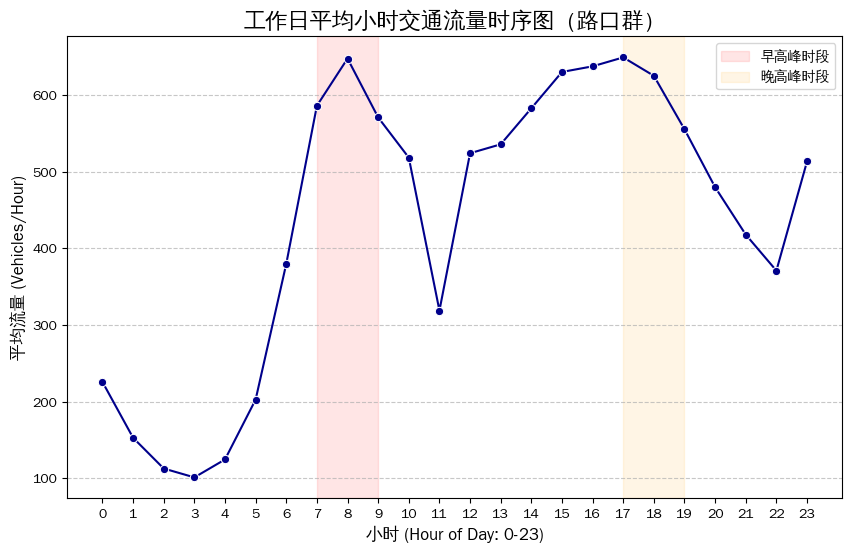

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 计算每个小时的平均流量
# 排除周末数据，只看典型工作日数据（Is_Weekend == False）
df_weekday = df_final[df_final['Is_Weekend'] == False]
hourly_avg_volume = df_weekday.groupby('Hour_of_Day')['Volume'].mean().reset_index()

# 2. 绘图设置
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=hourly_avg_volume,
    x='Hour_of_Day',
    y='Volume',
    marker='o',
    color='darkblue'
)

# 3. 标记高峰小时和专业化标题
plt.title('工作日平均小时交通流量时序图（路口群）', fontsize=16)
plt.xlabel('小时 (Hour of Day: 0-23)', fontsize=12)
plt.ylabel('平均流量 (Vehicles/Hour)', fontsize=12)

# 标记早高峰 (7-9点) 和晚高峰 (17-19点)
plt.axvspan(7, 9, color='red', alpha=0.1, label='早高峰时段')
plt.axvspan(17, 19, color='orange', alpha=0.1, label='晚高峰时段')

# 确保 X 轴显示所有 24 个小时点
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

/tmp/ipython-input-497259651.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


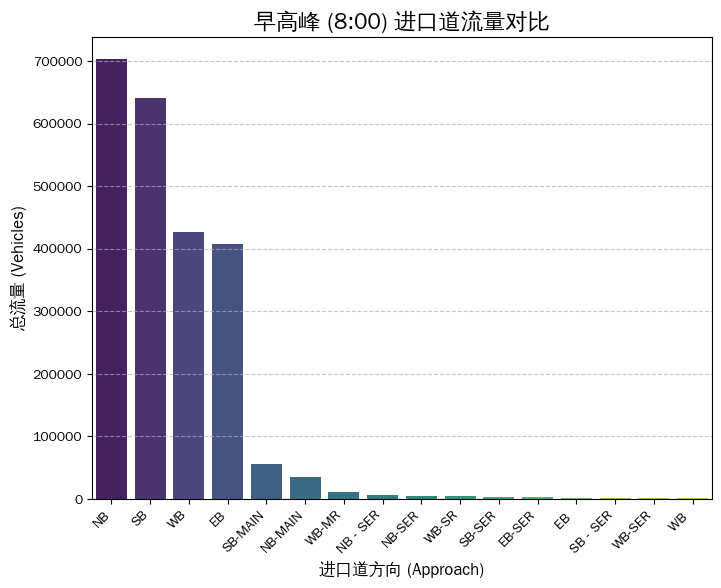

In [100]:
# 1. 筛选数据：只看工作日、早高峰小时（假设最拥堵的是 8 点）
PEAK_HOUR = 8
df_peak = df_final[
    (df_final['Is_Weekend'] == False) &
    (df_final['Hour_of_Day'] == PEAK_HOUR)
]

# 2. 按进口道分组，计算总流量
approach_volume = df_peak.groupby('Approach')['Volume'].sum().sort_values(ascending=False).reset_index()

# 3. 绘图设置
plt.figure(figsize=(8, 6))
# 使用柱状图对比不同进口道
sns.barplot(
    data=approach_volume,
    x='Approach',
    y='Volume',
    palette='viridis' # 使用色彩区分不同进口道
)

# 4. 标记专业化标题
plt.title(f'早高峰 ({PEAK_HOUR}:00) 进口道流量对比', fontsize=16)
plt.xlabel('进口道方向 (Approach)', fontsize=12)
plt.ylabel('总流量 (Vehicles)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipython-input-3940957962.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=volume_by_approach,


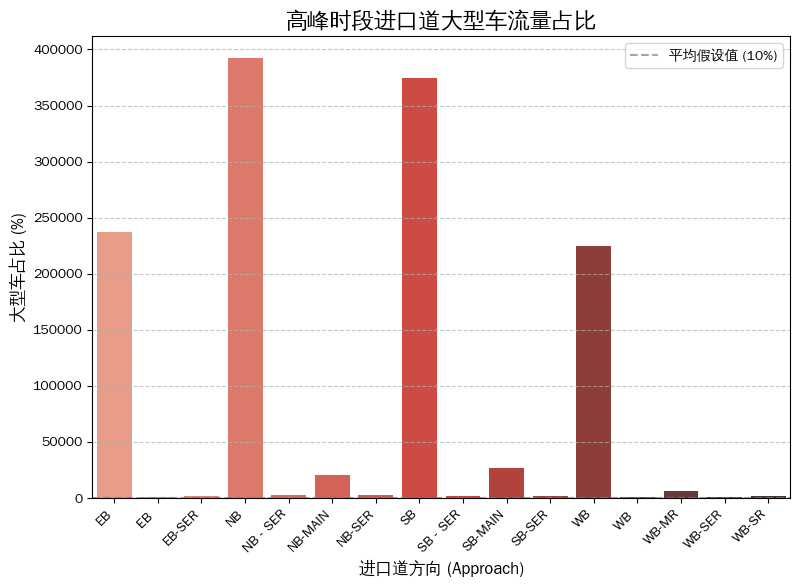

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 筛选数据：只看工作日高峰时段的数据（例如 7:00-9:00 和 17:00-19:00）
df_peak_hours = df_final[
    (df_final['Is_Weekend'] == False) &
    ((df_final['Hour_of_Day'] >= 7) & (df_final['Hour_of_Day'] <= 9) |
     (df_final['Hour_of_Day'] >= 17) & (df_final['Hour_of_Day'] <= 19))
]

# 2. 按进口道分组，计算总流量和总卡车流量
volume_by_approach = df_peak_hours.groupby('Approach').agg(
    Total_Volume=('Volume', 'sum'),
    Total_Truck_Volume=('Truck_Volume', 'sum')
).reset_index()

# 3. 计算大型车占比 (Truck Ratio)
# 这是假设的 10%，但按实际流量计算可以验证哪个进口道在高峰期流量更大。
volume_by_approach['Truck_Percentage'] = (volume_by_approach['Total_Truck_Volume'] / volume_by_approach['Total_Volume']) * 100
# 4. 绘图设置
plt.figure(figsize=(9, 6))
sns.barplot(data=volume_by_approach,
    x='Approach',
    y='Total_Truck_Volume',
    palette='Reds_d') # 使用红色系强调潜在的交通瓶颈


# 5. 标记专业化标题
plt.title('高峰时段进口道大型车流量占比', fontsize=16)
plt.xlabel('进口道方向 (Approach)', fontsize=12)
plt.ylabel('大型车占比 (%)', fontsize=12)
plt.axhline(y=10, color='grey', linestyle='--', alpha=0.7, label='平均假设值 (10%)') # 标出你的假设线
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()